# Libraries and Helper Functions

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
def plot_continuous(df, column_name, bins):
    no_readmission = df[df['READMISSION'] == False][column_name]
    readmission = df[df['READMISSION'] == True][column_name]

    plt.hist(no_readmission, bins, alpha=0.5, label='No Readmission')
    plt.hist(readmission, bins, alpha=0.5, label='Readmission')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(column_name + ' by Class')
    plt.legend(loc='upper right')
    plt.show()    

In [166]:
def plot_categorical(df, column_name, width):
    no_readmission_data = [(key, value) for key, value in df[df['READMISSION'] == False][column_name].value_counts().iteritems()]
    readmission_data = [(key, value) for key, value in df[df['READMISSION'] == True][column_name].value_counts().iteritems()]
    
    ind = np.arange(len(readmission_data))
    labels = np.asarray([value[0] for value in no_readmission_data])
    
    no_readmission = np.asarray([value[1] for value in no_readmission_data])
    readmission = np.asarray([value[1] for value in readmission_data])
    
    fig, ax = plt.subplots()
    
    no_readmission_axis = ax.bar(ind, no_readmission, width)
    readmission_axis = ax.bar(ind + width, readmission, width)
    
    ax.set_ylabel('Count')
    ax.set_title(column_name + ' by Class')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)

    ax.legend((no_readmission_axis[0], readmission_axis[0]), ('No Readmission', 'Readmission'))
    
    plt.show()

In [183]:
def convert_categorical(df, column_name):
    dummy_columns = pd.get_dummies(df[column_name])
    df = pd.concat([df, dummy_columns], axis = 1)
    df = df.drop(column_name, axis = 1)
    return df

# Classify Readmission Status for Each Record

In [167]:
admissions = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/ADMISSIONS.csv')

In [168]:
print(admissions.shape)
admissions.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [169]:
# get number of records for each subject id
subject_id_counts = admissions['SUBJECT_ID'].value_counts()

# mark all subject_ids with more than one record as case for readmission
admissions['READMISSION'] = admissions['SUBJECT_ID'].apply(lambda subject_id: subject_id_counts[subject_id] > 1)

In [170]:
# Only keep the first admission and drop any records where the patient died during the initial admission
main_df = admissions.drop_duplicates('SUBJECT_ID', keep = 'first')
main_df = main_df[main_df['DEATHTIME'].isnull()]
main_df = main_df[['SUBJECT_ID', 'HADM_ID', 'READMISSION']]

In [171]:
print(main_df.shape)
main_df.head()

(42115, 3)


,SUBJECT_ID,HADM_ID,READMISSION
0,22,165315,False
1,23,152223,True
3,24,161859,False
4,25,129635,False
5,26,197661,False


In [172]:
main_df.to_csv('full_dataset.csv', index = False)

# Format Admissions Features

In [173]:
admissions = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/ADMISSIONS.csv')
columns_to_keep = ['HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
                  'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME',
                  'HAS_CHARTEVENTS_DATA']
admissions = admissions[columns_to_keep]
main_df = main_df.merge(admissions, how = 'left', on = 'HADM_ID')

In [174]:
print(main_df.shape)
main_df.head()

(42115, 16)


,SUBJECT_ID,HADM_ID,READMISSION,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,HAS_CHARTEVENTS_DATA
0,22,165315,False,2196-04-09 12:26:00,2196-04-10 15:54:00,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,1
1,23,152223,True,2153-09-03 07:15:00,2153-09-08 19:10:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,1
2,24,161859,False,2139-06-06 16:14:00,2139-06-09 12:48:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,1
3,25,129635,False,2160-11-02 02:06:00,2160-11-05 14:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,1
4,26,197661,False,2126-05-06 15:16:00,2126-05-13 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,1


#### Length of Stay

In [175]:
print(main_df['ADMITTIME'].max())
print(main_df['DISCHTIME'].max())
print(main_df['ADMITTIME'].min())
print(main_df['DISCHTIME'].min())

2206-05-30 00:51:00
2206-06-10 15:59:00
2100-06-07 19:59:00
2100-06-09 17:09:00


In [176]:
def adjust_years(date, decrease_factor):
    year_old = date[:4]
    year_new = str(int(year_old) - decrease_factor)
    date = date.replace(year_old, year_new)
    return date

main_df['ADMITTIME'] = main_df['ADMITTIME'].apply(lambda date: adjust_years(date, 200))
main_df['DISCHTIME'] = main_df['DISCHTIME'].apply(lambda date: adjust_years(date, 200))
main_df['ADMITTIME'] = pd.to_datetime(main_df['ADMITTIME'])
main_df['DISCHTIME'] = pd.to_datetime(main_df['DISCHTIME'])

In [177]:
main_df['DURATION_OF_STAY'] = main_df['DISCHTIME'] - main_df['ADMITTIME']
main_df['DURATION_OF_STAY'] = main_df['DURATION_OF_STAY'].dt.days * 24 + main_df['DURATION_OF_STAY'].dt.seconds * 1.0 / 3600
main_df = main_df.drop(['ADMITTIME', 'DISCHTIME'], axis = 1)

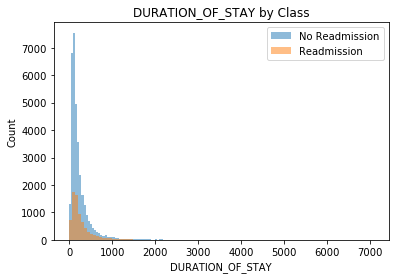

In [178]:
plot_continuous(main_df, 'DURATION_OF_STAY', 100)

#### Admission Type

In [179]:
main_df['ADMISSION_TYPE'].value_counts()

EMERGENCY    27185
NEWBORN       7767
ELECTIVE      6147
URGENT        1016
Name: ADMISSION_TYPE, dtype: int64

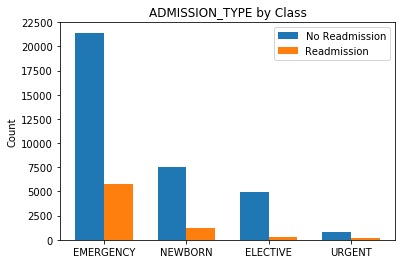

In [180]:
plot_categorical(main_df, 'ADMISSION_TYPE', 0.35)

In [184]:
main_df = convert_categorical(main_df, 'ADMISSION_TYPE')

#### Admission Location

In [186]:
main_df['ADMISSION_LOCATION'].value_counts()

EMERGENCY ROOM ADMIT         14391
PHYS REFERRAL/NORMAL DELI    12722
CLINIC REFERRAL/PREMATURE     8200
TRANSFER FROM HOSP/EXTRAM     6353
** INFO NOT AVAILABLE **       201
TRANSFER FROM SKILLED NUR      127
HMO REFERRAL/SICK               99
TRANSFER FROM OTHER HEALT       20
TRSF WITHIN THIS FACILITY        2
Name: ADMISSION_LOCATION, dtype: int64

In [189]:
# consolidate small categories
top_categories = [key for key, value in main_df['ADMISSION_LOCATION'].value_counts().iteritems() if value > 5000]
main_df['ADMISSION_LOCATION'] = main_df['ADMISSION_LOCATION'].apply(lambda x: x if x in top_categories else 'Other Admission Location')

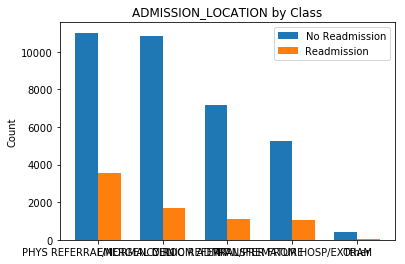

In [190]:
plot_categorical(main_df, 'ADMISSION_LOCATION', 0.35)

In [191]:
main_df = convert_categorical(main_df, 'ADMISSION_LOCATION')